## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from ast import literal_eval
import chardet
import ast
import seaborn as sns
#import os

## CSV preprocessing

The export of threats from the EDR API has more than 130 fields, in this section we keep the most relevant ones to carry out our entire analysis.

Function to get the indicators from the raw dataframe format and convert it into a sigular array object

In [2]:
def getIndicatorList(indicator):
    if (type(indicator)==str):
        indicator=literal_eval(indicator)
    arr=[]
    for i in range(len(indicator)):
        for j in range(len(indicator[i]['ids'])):
            arr.append(indicator[i]['ids'][j])
    return np.array(arr)

# Definir la función arrayToString
def arrayToString(arr):
    return ' '.join(map(str, sorted(arr)))

In [3]:
# Función para extraer el valor del campo 'action' de la columna 'mitigationStatus'
def get_action(mitigation_status):
    if pd.isna(mitigation_status):
        return None
    parsed_status = ast.literal_eval(mitigation_status)
    if isinstance(parsed_status, list) and len(parsed_status) > 0 and 'action' in parsed_status[0]:
        return parsed_status[0]['action']
    return None

In [4]:
# Función para extraer el valor del campo 'title' de la columna 'threatInfo.detectionEngines'
def get_title(detection_engines):
    if pd.isna(detection_engines):
        return None
    try:
        parsed_engines = ast.literal_eval(detection_engines)
        if isinstance(parsed_engines, list) and len(parsed_engines) > 0 and 'title' in parsed_engines[0]:
            return parsed_engines[0]['title']
    except (ValueError, SyntaxError):
        return None

Open and read the Dataset, and parse it into a pandas dataframe

In [5]:
# Ruta del archivo CSV proporcionado por el usuario
csv_file_path = "C:\\Users\\alber\\Documents\\Máster IA de UNIR\\Asignaturas\\TFE\\Código\\MergedOutput.csv"

# Detectar la codificación del archivo
with open(csv_file_path, 'rb') as f:
    result = chardet.detect(f.read(100000))
    encoding = result['encoding']

# Leer el archivo CSV utilizando la codificación detectada
df = pd.read_csv(csv_file_path, encoding=encoding, sep=None, engine='python')
df = df.drop(columns=["Unnamed: 0"], axis=1)

# Mostrar las primeras filas del DataFrame para verificar el contenido
#print(df.head())


In [6]:
    
# ThreatIndicatorList
df["indicatorList"] = df["indicators"].apply(getIndicatorList)

# Eliminar saltos de línea en 'indicatorList'
df['indicatorList'] = df['indicatorList'].apply(lambda x: ' '.join(str(x).split()))

# MitigationStatus
df['action'] = df['mitigationStatus'].apply(get_action)

# Aplicar la función a la columna 'threatInfo.detectionEngines'
if 'threatInfo.detectionEngines' in df.columns:
    df['engine'] = df['threatInfo.detectionEngines'].apply(get_title)
else:
    df['engine'] = None

#print(df[["threatInfo.threatId","threatInfo.threatName","threatInfo.classification","threatInfo.confidenceLevel","threatInfo.analystVerdict","threatInfo.createdAt","threatInfo.identifiedAt","threatInfo.updatedAt","indicatorList","threatInfo.detectionType","action","threatInfo.sha1","engine"]])


##### Drop all rows that do not have any threat indicators associated with them. 
Note: Usually it's the threats detected from static analysis (not always)

In [7]:
# Función para preprocesar los valores en 'indicatorList'
def preprocess_indicator_list(val):
    if isinstance(val, str):
        # Reemplazar espacios con comas y agregar comas donde sea necesario
        val = val.replace(' ', ',')
        val = val.replace('[,', '[').replace(',]', ']')
        return ast.literal_eval(val)
    return val

# Aplicar la función de preprocesamiento
df['indicatorList'] = df['indicatorList'].apply(preprocess_indicator_list)

# Eliminar filas donde 'indicatorList' está vacío (después de asegurarnos que todos son listas)
df = df.drop(df[df['indicatorList'].apply(lambda x: isinstance(x, list) and len(x) == 0)].index)

# Convertir 'indicatorList' a una cadena de texto ordenada
def arrayToString(arr):
    if isinstance(arr, list):
        return ' '.join(map(str, sorted(arr)))
    return str(arr)

df['indicatorListString'] = df['indicatorList'].apply(arrayToString)

# Eliminar filas duplicadas basadas en 'threatInfo.sha1'
##df = df.drop_duplicates(subset=['threatInfo.sha1'])
df = df.drop_duplicates(subset=['threatInfo.threatName'])

# Mostrar las columnas 'id', 'indicatorList', y 'threatInfo.sha1'
df_subset = df[["id", "indicatorList", "threatInfo.sha1"]]

There are some threats (less than 30) that are not parsed well because they contain a comma in some description, we discard them. To do this, we take as a reference the value of the threatInfo.confidenceLevel column, which is always malicious or suspicious. If it is another value, it means that it was parsed incorrectly.

In [8]:
# Crear un subconjunto del DataFrame con las columnas especificadas
subset_columns = df[[
    "threatInfo.threatId",
    "threatInfo.threatName",
    "threatInfo.classification",
    "threatInfo.confidenceLevel",
    "threatInfo.analystVerdict",
    "threatInfo.createdAt",
    "threatInfo.identifiedAt",
    "threatInfo.updatedAt",
    "indicatorList",
    "indicatorListString",
    "threatInfo.detectionType",
    "action",
    "threatInfo.sha1",
    "engine"
]]

# Filtrar las columnas que existen en el DataFrame
subset_columns = [col for col in subset_columns if col in df.columns]

# Crear el subconjunto del DataFrame
subset_df = df[subset_columns]

# Filtrar las filas donde el valor de la columna 'threatInfo.confidenceLevel' es 'malicious' o 'suspicious'
filtered_df = subset_df[subset_df['threatInfo.confidenceLevel'].isin(['malicious', 'suspicious'])]

# Guardar el subconjunto del DataFrame en un nuevo archivo CSV
filtered_df.to_csv('C:\\Users\\alber\\Documents\\Máster IA de UNIR\\Asignaturas\\TFE\\Código\\Subset.csv', index=False)

print("El archivo CSV con el subconjunto especificado se ha guardado correctamente.")

El archivo CSV con el subconjunto especificado se ha guardado correctamente.


## EDA

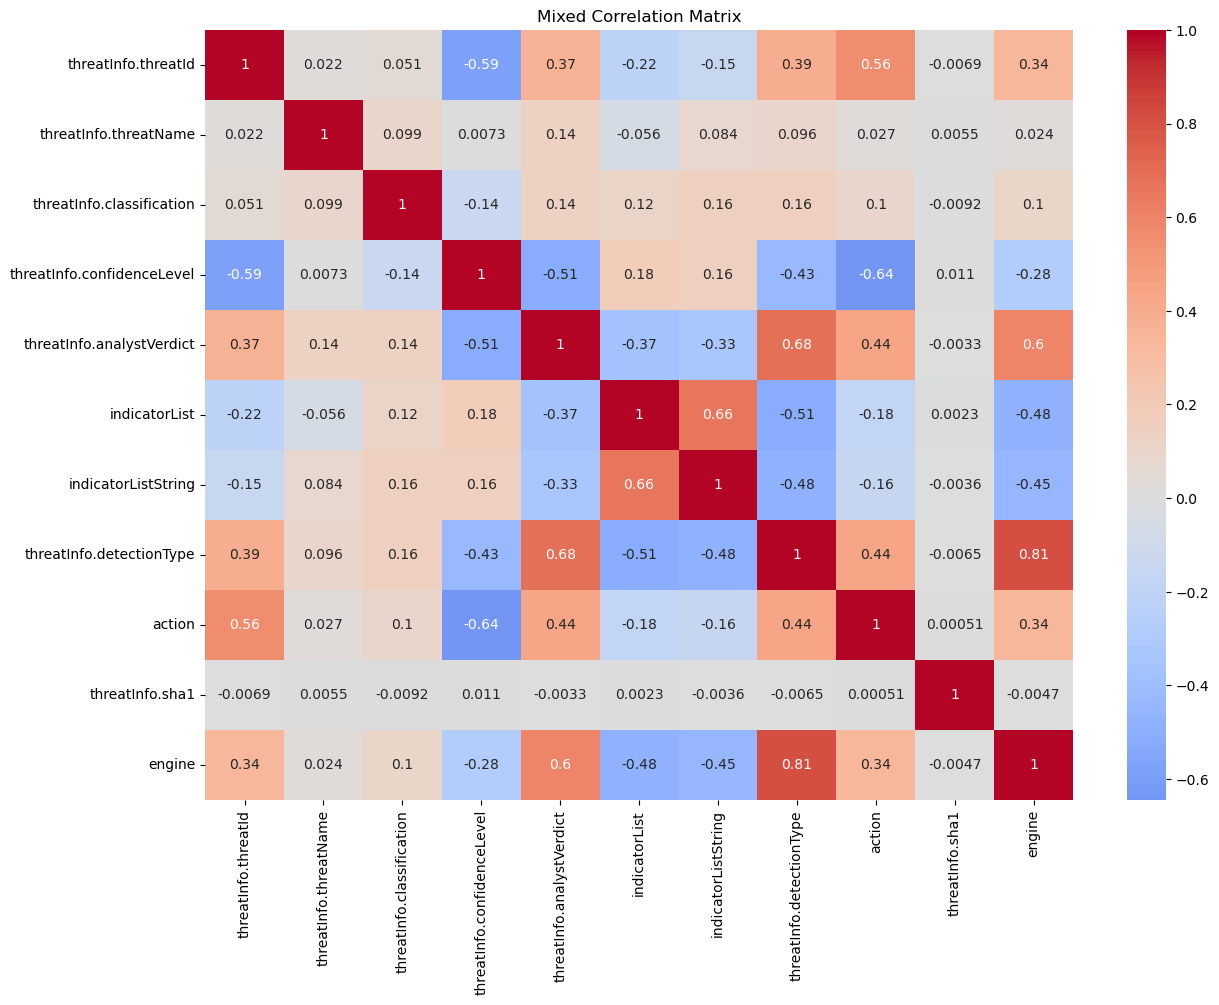


Top Correlaciones Más Fuertes:
                      Variable 1                  Variable 2  Correlation
87     threatInfo.detectionType                      engine     0.812652
117                      engine    threatInfo.detectionType     0.812652
81     threatInfo.detectionType   threatInfo.analystVerdict     0.683442
51    threatInfo.analystVerdict    threatInfo.detectionType     0.683442
71          indicatorListString               indicatorList     0.659411
61                indicatorList         indicatorListString     0.659411
91                       action  threatInfo.confidenceLevel    -0.644670
41   threatInfo.confidenceLevel                      action    -0.644670
114                      engine   threatInfo.analystVerdict     0.595757
54    threatInfo.analystVerdict                      engine     0.595757
3           threatInfo.threatId  threatInfo.confidenceLevel    -0.591145
33   threatInfo.confidenceLevel         threatInfo.threatId    -0.591145
88                

In [9]:
from scipy.stats import spearmanr, kendalltau
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

# Crear un subconjunto del DataFrame con las columnas sin tiempo
subset_columns = df[[
    "threatInfo.threatId",
    "threatInfo.threatName",
    "threatInfo.classification",
    "threatInfo.confidenceLevel",
    "threatInfo.analystVerdict",
    "indicatorList",
    "indicatorListString",
    "threatInfo.detectionType",
    "action",
    "threatInfo.sha1",
    "engine"
]]

# Filtrar las columnas que existen en el DataFrame
subset_columns = [col for col in subset_columns if col in df.columns]

# Crear el subconjunto del DataFrame
subset_df = df[subset_columns]
df = subset_df

# Definir una función para calcular la matriz de correlación mixta
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg), 2)))
    denominator = np.sum(np.power(np.subtract(measurements, y_total_avg), 2))
    if numerator == 0:
        return 0.0
    else:
        return np.sqrt(numerator / denominator)

# Convertir variables categóricas en etiquetas numéricas para calcular correlaciones
le = LabelEncoder()
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

# Calcular la matriz de correlación mixta
correlation_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

for col1 in df.columns:
    for col2 in df.columns:
        if df[col1].dtype == 'object' or df[col2].dtype == 'object':
            correlation_matrix.loc[col1, col2] = correlation_ratio(df[col1], df[col2])
        else:
            correlation_matrix.loc[col1, col2] = np.corrcoef(df[col1], df[col2])[0, 1]

correlation_matrix = correlation_matrix.astype(float)

# Visualizar la matriz de correlación mixta
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Mixed Correlation Matrix')
plt.show()

# Obtener el top 5 de correlaciones más fuertes (excluyendo la diagonal)
corr_pairs = correlation_matrix.unstack().reset_index()
corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
corr_pairs = corr_pairs[corr_pairs['Variable 1'] != corr_pairs['Variable 2']]
top_5_correlations = corr_pairs.reindex(corr_pairs.Correlation.abs().sort_values(ascending=False).index).head(20)

print("\nTop Correlaciones Más Fuertes:\n", top_5_correlations)

In [41]:
# Gráfico de Barras Apiladas
#plt.figure(figsize=(14, 7))
#sns.countplot(data=filtered_df, x='engine', hue='threatInfo.analystVerdict')
#plt.title('Distribución de "engine" por "threatInfo.analystVerdict"')
#plt.xticks(rotation=45)
#plt.show()

In [10]:
# Crear una tabla cruzada
#cross_tab = pd.crosstab(filtered_df['engine'], filtered_df['threatInfo.analystVerdict'])

# Heatmap
#plt.figure(figsize=(14, 7))
#sns.heatmap(cross_tab, annot=True, fmt="d", cmap="YlGnBu")
#plt.title('Heatmap de "engine" y "threatInfo.analystVerdict"')
#plt.show()

In [11]:
# Contar frecuencias de cada combinación
#freq = filtered_df.groupby(['engine', 'threatInfo.analystVerdict']).size().reset_index(name='counts')

# Gráfico de Barras
#plt.figure(figsize=(14, 7))
#sns.barplot(data=freq, x='engine', y='counts', hue='threatInfo.analystVerdict')
#plt.title('Frecuencia de "engine" por "threatInfo.analystVerdict"')
#plt.xticks(rotation=45)
#plt.show()

In [12]:
# Calcular porcentajes
#engine_verdict_counts = filtered_df.groupby(['engine', 'threatInfo.analystVerdict']).size().reset_index(name='counts')
#total_counts = engine_verdict_counts.groupby('engine')['counts'].transform('sum')
#engine_verdict_counts['percentage'] = engine_verdict_counts['counts'] / total_counts * 100

# Gráfico de Barras Apiladas con Porcentajes
#plt.figure(figsize=(14, 7))
#sns.barplot(data=engine_verdict_counts, x='engine', y='percentage', hue='threatInfo.analystVerdict')
#plt.title('Distribución de "engine" por "threatInfo.analystVerdict" (Porcentajes)')
#plt.ylabel('Porcentaje')
#plt.xticks(rotation=45)
#plt.show()

In [13]:
# Crear una tabla cruzada con conteos
#cross_tab = pd.crosstab(filtered_df['engine'], filtered_df['threatInfo.analystVerdict'], normalize='index') * 100

# Heatmap con Porcentajes
#plt.figure(figsize=(14, 7))
#sns.heatmap(cross_tab, annot=True, fmt=".1f", cmap="YlGnBu")
#plt.title('Heatmap de "engine" y "threatInfo.analystVerdict" (Porcentajes)')
#plt.ylabel('Engine')
#plt.xlabel('ThreatInfo Analyst Verdict')
#plt.show()

In [14]:
# Calcular porcentajes
#engine_verdict_counts = filtered_df.groupby(['engine', 'threatInfo.analystVerdict']).size().reset_index(name='counts')
#total_counts = engine_verdict_counts.groupby('engine')['counts'].transform('sum')
#engine_verdict_counts['percentage'] = engine_verdict_counts['counts'] / total_counts * 100

# Gráfico de Barras con Porcentajes
#plt.figure(figsize=(14, 7))
#sns.barplot(data=engine_verdict_counts, x='engine', y='percentage', hue='threatInfo.analystVerdict')
#plt.title('Frecuencia de "engine" por "threatInfo.analystVerdict" (Porcentajes)')
#plt.ylabel('Porcentaje')
#plt.xticks(rotation=45)
#plt.show()

In [15]:
# Contar el número de threatInfo.threatId por cada valor de engine
#engine_counts = filtered_df.groupby('engine')['threatInfo.threatId'].count()

# Crear el gráfico de quesitos
#plt.figure(figsize=(12, 8))
#wedges, texts, autotexts = plt.pie(
#    engine_counts, autopct='%1.1f%%', startangle=140, pctdistance=0.85, textprops=dict(color="w")
#)

# Añadir estilo a los textos
#for text in texts:
#    text.set_color('black')
#    text.set_fontsize(10)
#for autotext in autotexts:
#    autotext.set_color('black')
#    autotext.set_fontsize(8)

# Añadir leyenda fuera del gráfico
'''
plt.legend(wedges, engine_counts.index, title="Engine", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribución de threatInfo.threatId por engine')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
'''

'\nplt.legend(wedges, engine_counts.index, title="Engine", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))\n\nplt.title(\'Distribución de threatInfo.threatId por engine\')\nplt.axis(\'equal\')  # Equal aspect ratio ensures that pie is drawn as a circle.\n\nplt.show()\n'

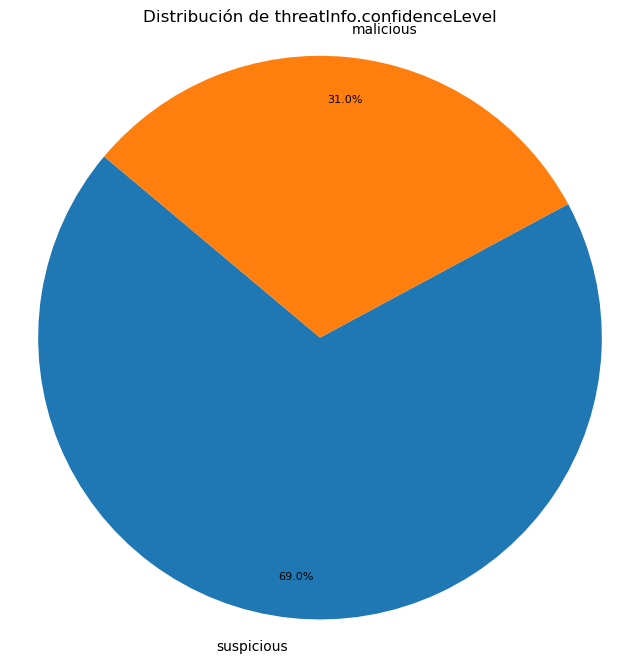

In [17]:
# Contar el número de ocurrencias por cada valor de threatInfo.confidenceLevel
confidence_level_counts = filtered_df['threatInfo.confidenceLevel'].value_counts()

# Crear el gráfico de quesitos para threatInfo.confidenceLevel
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    confidence_level_counts, labels=confidence_level_counts.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85
)

# Añadir estilo a los textos
for text in texts:
    text.set_color('black')
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(8)

plt.title('Distribución de threatInfo.confidenceLevel')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

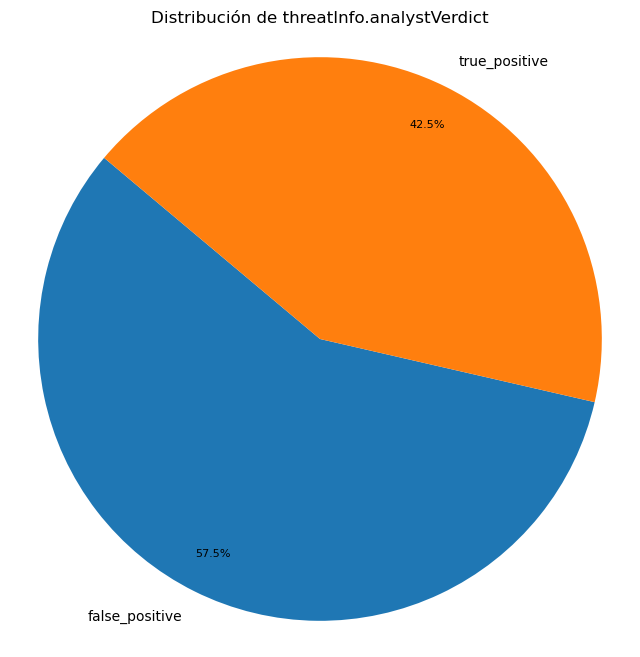

In [18]:
# Contar el número de ocurrencias por cada valor de threatInfo.analystVerdict
analyst_verdict_counts = filtered_df['threatInfo.analystVerdict'].value_counts()

# Crear el gráfico de quesitos para threatInfo.analystVerdict
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    analyst_verdict_counts, labels=analyst_verdict_counts.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85
)

# Añadir estilo a los textos
for text in texts:
    text.set_color('black')
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(8)

plt.title('Distribución de threatInfo.analystVerdict')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [16]:
'''
# Crear una tabla cruzada con conteos
cross_tab = pd.crosstab(filtered_df['threatInfo.classification'], filtered_df['threatInfo.analystVerdict'], normalize='index') * 100

# Heatmap con Porcentajes
plt.figure(figsize=(14, 7))
sns.heatmap(cross_tab, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Heatmap de "threatInfo.classification" y "threatInfo.analystVerdict" (Porcentajes)')
plt.ylabel('Classification')
plt.xlabel('ThreatInfo Analyst Verdict')
plt.show()
'''

'\n# Crear una tabla cruzada con conteos\ncross_tab = pd.crosstab(filtered_df[\'threatInfo.classification\'], filtered_df[\'threatInfo.analystVerdict\'], normalize=\'index\') * 100\n\n# Heatmap con Porcentajes\nplt.figure(figsize=(14, 7))\nsns.heatmap(cross_tab, annot=True, fmt=".1f", cmap="YlGnBu")\nplt.title(\'Heatmap de "threatInfo.classification" y "threatInfo.analystVerdict" (Porcentajes)\')\nplt.ylabel(\'Classification\')\nplt.xlabel(\'ThreatInfo Analyst Verdict\')\nplt.show()\n'

In [17]:
'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una tabla cruzada con conteos
cross_tab_counts = pd.crosstab(filtered_df['threatInfo.classification'], filtered_df['threatInfo.analystVerdict'])

# Heatmap con Conteos
plt.figure(figsize=(14, 7))
sns.heatmap(cross_tab_counts, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Heatmap de "threatInfo.classification" y "threatInfo.analystVerdict"')
plt.ylabel('Classification')
plt.xlabel('ThreatInfo Analyst Verdict')
plt.show()
'''

'\nimport pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Crear una tabla cruzada con conteos\ncross_tab_counts = pd.crosstab(filtered_df[\'threatInfo.classification\'], filtered_df[\'threatInfo.analystVerdict\'])\n\n# Heatmap con Conteos\nplt.figure(figsize=(14, 7))\nsns.heatmap(cross_tab_counts, annot=True, fmt="d", cmap="YlGnBu")\nplt.title(\'Heatmap de "threatInfo.classification" y "threatInfo.analystVerdict"\')\nplt.ylabel(\'Classification\')\nplt.xlabel(\'ThreatInfo Analyst Verdict\')\nplt.show()\n'

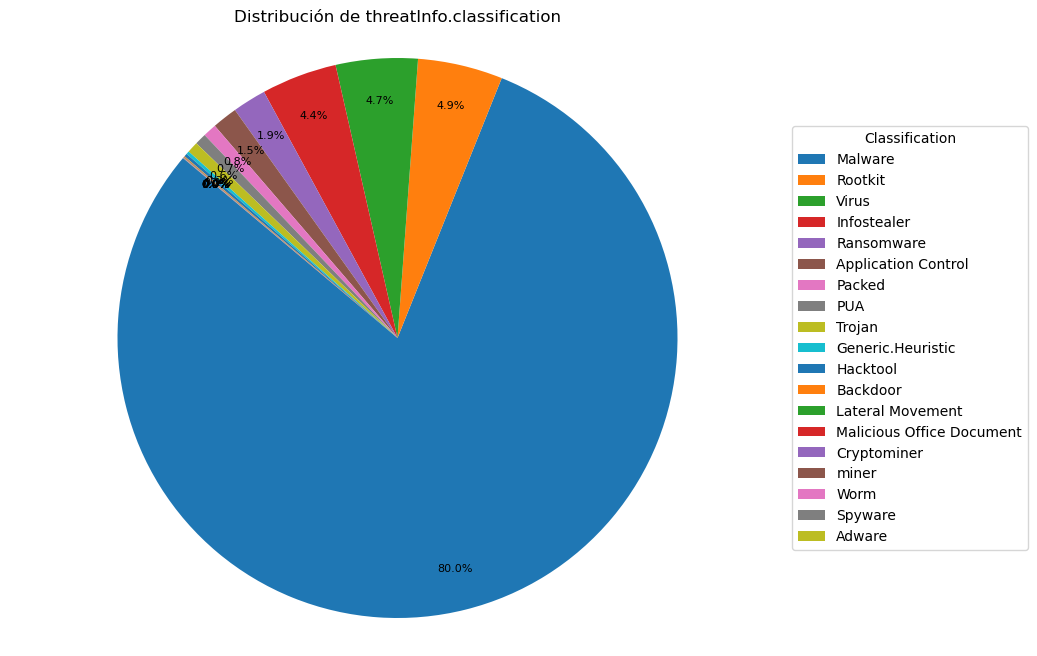

In [21]:
# Contar el número de ocurrencias por cada valor de threatInfo.classification
classification_counts = filtered_df['threatInfo.classification'].value_counts()

# Crear el gráfico de quesitos para threatInfo.classification
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    classification_counts, autopct='%1.1f%%', startangle=140, pctdistance=0.85, textprops=dict(color="w")
)

# Añadir estilo a los textos
for text in texts:
    text.set_color('black')
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(8)

# Añadir leyenda fuera del gráfico
plt.legend(wedges, classification_counts.index, title="Classification", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribución de threatInfo.classification')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

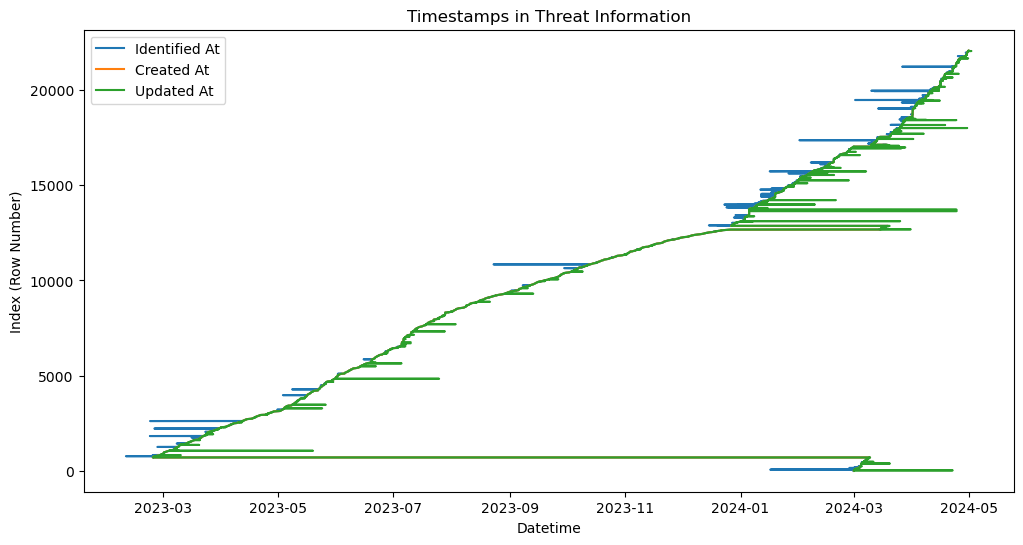

In [22]:

# Convertir las columnas temporales a datetime
filtered_df['threatInfo.identifiedAt'] = pd.to_datetime(filtered_df['threatInfo.identifiedAt'], errors='coerce')
filtered_df['threatInfo.createdAt'] = pd.to_datetime(filtered_df['threatInfo.createdAt'], errors='coerce')
filtered_df['threatInfo.updatedAt'] = pd.to_datetime(filtered_df['threatInfo.updatedAt'], errors='coerce')

# Eliminar filas con valores nulos en las columnas de tiempo
filtered_df = filtered_df.dropna(subset=['threatInfo.identifiedAt', 'threatInfo.createdAt', 'threatInfo.updatedAt'])

# Mostrar las primeras filas del DataFrame para verificar los cambios
filtered_df[['threatInfo.identifiedAt', 'threatInfo.createdAt', 'threatInfo.updatedAt']].head()

# Visualizar las columnas temporales en un gráfico con Datetime en el eje x
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['threatInfo.identifiedAt'], filtered_df.index, label='Identified At')
plt.plot(filtered_df['threatInfo.createdAt'], filtered_df.index, label='Created At')
plt.plot(filtered_df['threatInfo.updatedAt'], filtered_df.index, label='Updated At')
plt.xlabel('Datetime')
plt.ylabel('Index (Row Number)')
plt.title('Timestamps in Threat Information')
plt.legend()
plt.show()

### Análisis de los Threat Indicators

In [28]:
def find_get_index(val, arr):
    for i in range(len(arr)):
        if(val == arr[i]):
            return i
    return -1

This block is to aggregate the sum of indicators over all the threats and get a data on which indicators are triggered the most.

In [29]:
indicator_count ={"indicator":[], "count":[]}
for i in range(len(filtered_df)):
    for j in filtered_df.iloc[i]['indicatorList']:
        try:
            index = find_get_index(j,indicator_count['indicator'])
            #print(j,index)
            if(index>=0):
                indicator_count['count'][index] = indicator_count['count'][index]+1
            else:
                indicator_count['indicator'].append(j)
                indicator_count['count'].append(1)
        except:
            print(f"Caught Exception: Failed to create indicator count dataframe. \nState: Indicator: {j}\nDataFrame Index: {i}")
indicator_count_df= pd.DataFrame.from_dict(indicator_count)
indicator_count_df.head(5)
#indicator_df=pd.DataFrame.from_dict(indicator_count)
#indicator_df

,indicator,count
0,24,2605
1,7,372
2,6,2122
3,1,3289
4,817,80


Create dataframe with the indicator frequency count and plot a pie chart to visualize which indicators are the most commonly triggered

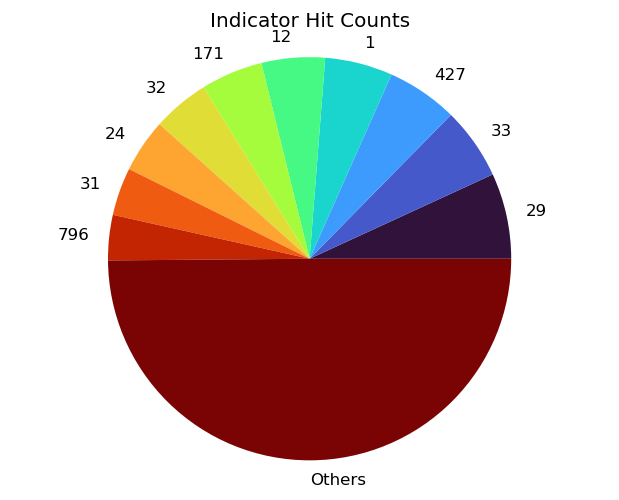

In [30]:
indicator_count_df = indicator_count_df.sort_values(by="count", ascending=False)
TopCount = 10
top_indicators = indicator_count_df.head(TopCount)
remaining_values = pd.Series({'indicator':"Others","count":indicator_count_df['count'][TopCount:].sum()})

final_indicator_count_df = pd.concat([top_indicators,remaining_values.to_frame().T])


colormap = plt.cm.turbo
colors = colormap(np.linspace(0,1,TopCount+1))
plt.rcParams['figure.dpi'] = 120
plt.pie(final_indicator_count_df["count"], labels=final_indicator_count_df["indicator"], colors=colors)
plt.title("Indicator Hit Counts")
plt.axis("equal")
plt.show()
#fig.show()

# Indicators for True Positives

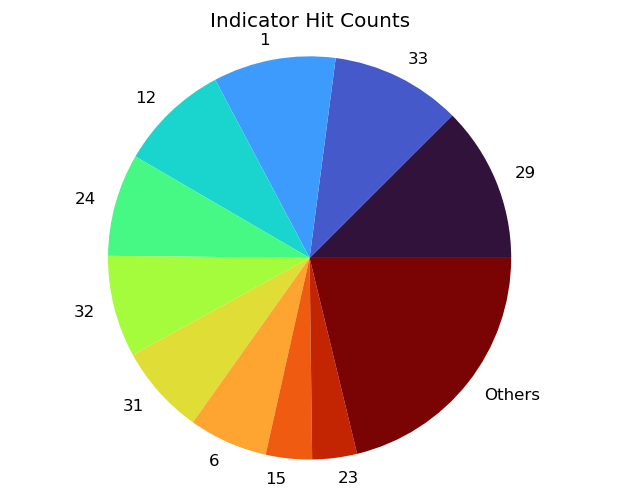

In [31]:
indicator_count ={"indicator":[], "count":[]}
for i in range(len(filtered_df)):
    if(filtered_df.iloc[i]['threatInfo.analystVerdict']=="true_positive"):
        for j in filtered_df.iloc[i]['indicatorList']:
            try:
                index = find_get_index(j,indicator_count['indicator'])
                #print(j,index)
                if(index>=0):
                    indicator_count['count'][index] = indicator_count['count'][index]+1
                else:
                    indicator_count['indicator'].append(j)
                    indicator_count['count'].append(1)
            except:
                print(f"Caught Exception: Failed to create indicator count dataframe. \nState: Indicator: {j}\nDataFrame Index: {i}")
indicator_count_df= pd.DataFrame.from_dict(indicator_count)
indicator_count_df.head(5)
#indicator_df=pd.DataFrame.from_dict(indicator_count)
#indicator_df


indicator_count_df = indicator_count_df.sort_values(by="count", ascending=False)
TopCount = 10
top_indicators = indicator_count_df.head(TopCount)
remaining_values = pd.Series({'indicator':"Others","count":indicator_count_df['count'][TopCount:].sum()})

final_indicator_count_df = pd.concat([top_indicators,remaining_values.to_frame().T])


colormap = plt.cm.turbo
colors = colormap(np.linspace(0,1,TopCount+1))
plt.rcParams['figure.dpi'] = 120
plt.pie(final_indicator_count_df["count"], labels=final_indicator_count_df["indicator"], colors=colors)
plt.title("Indicator Hit Counts")
plt.axis("equal")
plt.show()

# Indicators for False Positives

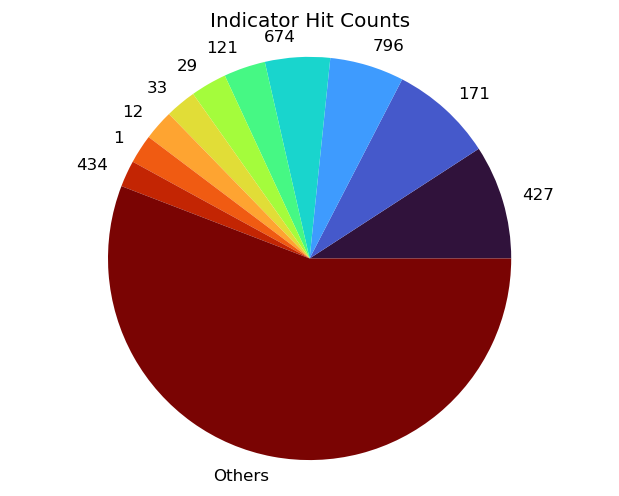

In [32]:
indicator_count ={"indicator":[], "count":[]}
for i in range(len(filtered_df)):
    if(filtered_df.iloc[i]['threatInfo.analystVerdict']=="false_positive"):
        for j in filtered_df.iloc[i]['indicatorList']:
            try:
                index = find_get_index(j,indicator_count['indicator'])
                #print(j,index)
                if(index>=0):
                    indicator_count['count'][index] = indicator_count['count'][index]+1
                else:
                    indicator_count['indicator'].append(j)
                    indicator_count['count'].append(1)
            except:
                print(f"Caught Exception: Failed to create indicator count dataframe. \nState: Indicator: {j}\nDataFrame Index: {i}")
indicator_count_df= pd.DataFrame.from_dict(indicator_count)
indicator_count_df.head(5)
#indicator_df=pd.DataFrame.from_dict(indicator_count)
#indicator_df


indicator_count_df = indicator_count_df.sort_values(by="count", ascending=False)
TopCount = 10
top_indicators = indicator_count_df.head(TopCount)
remaining_values = pd.Series({'indicator':"Others","count":indicator_count_df['count'][TopCount:].sum()})

final_indicator_count_df = pd.concat([top_indicators,remaining_values.to_frame().T])


colormap = plt.cm.turbo
colors = colormap(np.linspace(0,1,TopCount+1))
plt.rcParams['figure.dpi'] = 120
plt.pie(final_indicator_count_df["count"], labels=final_indicator_count_df["indicator"], colors=colors)
plt.title("Indicator Hit Counts")
plt.axis("equal")
plt.show()

In [33]:
from sklearn import preprocessing

In [34]:
le = preprocessing.LabelEncoder()
filtered_df['threatInfo.analystVerdict.encoded'] = le.fit_transform(filtered_df['threatInfo.analystVerdict'])
filtered_df[['threatInfo.analystVerdict.encoded','threatInfo.analystVerdict']]

,threatInfo.analystVerdict.encoded,threatInfo.analystVerdict
0,1,true_positive
1,1,true_positive
2,0,false_positive
3,1,true_positive
4,1,true_positive
...,...,...
22059,1,true_positive
22064,0,false_positive
22065,0,false_positive
22073,0,false_positive


In [18]:
#print((indicator_count_df['indicator']).to_string())

In [19]:
#indicator_count_df

In [20]:
filtered_df['threatInfo.analystVerdict'].value_counts()

threatInfo.analystVerdict
false_positive    7440
true_positive     5496
Name: count, dtype: int64

In [21]:
filtered_df.loc[df['threatInfo.analystVerdict']=="true_positive"]["indicatorListString"]


Series([], Name: indicatorListString, dtype: object)

In [22]:
filtered_df.loc[df['threatInfo.analystVerdict']=="false_positive"]["indicatorList"]

Series([], Name: indicatorList, dtype: object)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import resample
from sklearn import preprocessing, svm
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE

#### Convert multivariate indicator array list to Binary

In [24]:
#mlb = MultiLabelBinarizer()
#characteristics_encoded = pd.DataFrame(mlb.fit_transform(filtered_df['indicatorList']), columns=mlb.classes_, index=filtered_df.index)
#X = characteristics_encoded
#y = filtered_df['threatInfo.analystVerdict.encoded']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=0)


# Convertir 'indicatorListString' en una lista de strings
filtered_df['indicatorListString'] = filtered_df['indicatorListString'].apply(lambda x: x.split() if isinstance(x, str) else [])
print(filtered_df['indicatorListString'])

# Codificar 'indicatorList' utilizando MultiLabelBinarizer
mlb = MultiLabelBinarizer()
indicator_list_encoded = pd.DataFrame(mlb.fit_transform(filtered_df['indicatorListString']), columns=mlb.classes_, index=filtered_df.index)

print(indicator_list_encoded)

# Codificar 'engine' utilizando pd.get_dummies
engine_encoded = pd.get_dummies(filtered_df['engine'], prefix='engine')

# Codificar 'threatInfo.classification' utilizando pd.get_dummies
classification_encoded = pd.get_dummies(filtered_df['threatInfo.classification'], prefix='classification')

# Codificar 'threatInfo.confidenceLevel' utilizando pd.get_dummies
confidence_level_encoded = pd.get_dummies(filtered_df['threatInfo.confidenceLevel'], prefix='confidenceLevel')

# Codificar 'threatInfo.detectionType' utilizando pd.get_dummies
detection_type_encoded = pd.get_dummies(filtered_df['threatInfo.detectionType'], prefix='detectionType')

# Combinar todas las características codificadas en un solo DataFrame
characteristics_encoded = pd.concat([indicator_list_encoded, engine_encoded, classification_encoded, confidence_level_encoded, detection_type_encoded], axis=1)

# Verificar que las columnas de indicator_list_encoded están presentes
print("Columnas de indicator_list_encoded en characteristics_encoded:", set(indicator_list_encoded.columns).intersection(set(characteristics_encoded.columns)))

# Definir X y y
X = characteristics_encoded
y = filtered_df['threatInfo.analystVerdict.encoded']

# Convertir y a entero si es necesario
y = y.astype(int)

# Convertir todos los valores booleanos en X a enteros
X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Mostrar las dimensiones de los conjuntos de datos
print('Dimensiones de X_train:', X_train.shape)
print('Dimensiones de X_test:', X_test.shape)
print('Dimensiones de y_train:', y_train.shape)
print('Dimensiones de y_test:', y_test.shape)

# Verificar los tipos de datos de y_train
print("Tipos de datos de y_train:", y_train.dtypes)

# Aplicar SMOTE para equilibrar las clases
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


0                      [6, 7, 24]
1                             [1]
2                      [199, 817]
3                     [6, 12, 29]
4            [12, 20, 29, 31, 33]
                   ...           
22059                    [12, 15]
22064             [6, 23, 24, 25]
22065             [6, 23, 24, 25]
22073    [62, 121, 171, 427, 674]
22074             [6, 23, 24, 25]
Name: indicatorListString, Length: 12936, dtype: object
       1  10  1005  1007  101  1010  1011  1012  1016  1018  ...  983  986  \
0      0   0     0     0    0     0     0     0     0     0  ...    0    0   
1      1   0     0     0    0     0     0     0     0     0  ...    0    0   
2      0   0     0     0    0     0     0     0     0     0  ...    0    0   
3      0   0     0     0    0     0     0     0     0     0  ...    0    0   
4      0   0     0     0    0     0     0     0     0     0  ...    0    0   
...   ..  ..   ...   ...  ...   ...   ...   ...   ...   ...  ...  ...  ...   
22059  0   0     0     0

KeyError: 'threatInfo.analystVerdict.encoded'

In [42]:
X_train

,1,10,101,1010,1016,1018,102,103,104,1046,...,classification_Rootkit,classification_Spyware,classification_Trojan,classification_Virus,classification_Worm,classification_miner,confidenceLevel_malicious,confidenceLevel_suspicious,detectionType_dynamic,detectionType_static
13799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
20316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
16927,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2397,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8841,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
5170,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
17210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
18653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


# Entrenamiento de modelos

## Árbol de Decisiones

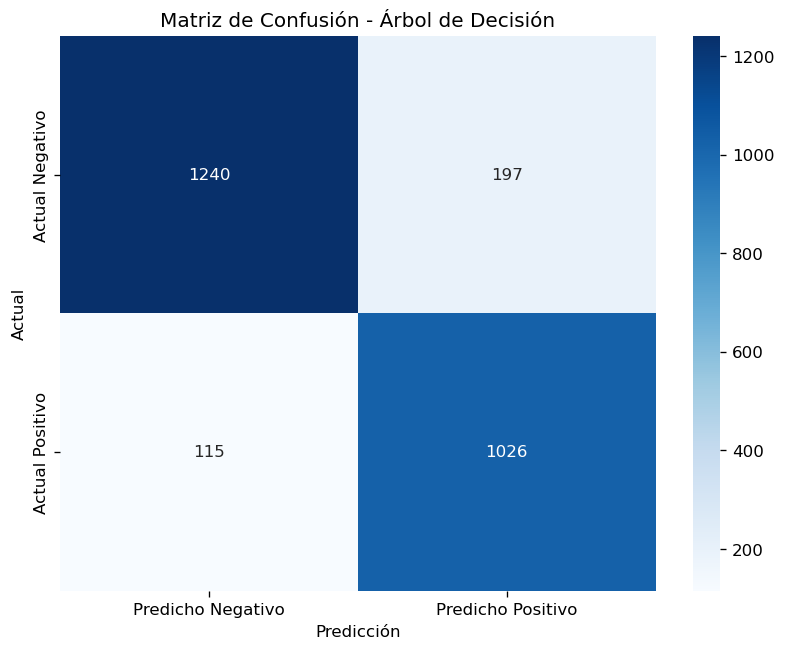

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1437
           1       0.84      0.90      0.87      1141

    accuracy                           0.88      2578
   macro avg       0.88      0.88      0.88      2578
weighted avg       0.88      0.88      0.88      2578



In [58]:
model = DecisionTreeClassifier()
# Entrenar el modelo con los datos balanceados
model.fit(X_resampled, y_resampled)


#model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))


Análisis:
Clase 0 (FP): Tiene alta precisión (95%) pero menor recall (77%), lo que indica que el modelo predice correctamente la mayoría de los casos positivos, pero pierde algunos casos reales positivos.
Clase 1 (TP): Tiene menor precisión (77%) pero alto recall (95%), lo que indica que el modelo predice correctamente la mayoría de los casos reales positivos, pero también predice algunos casos negativos como positivos.

## Modelo de Random Forest

Fitting 5 folds for each of 108 candidates, totalling 540 fits


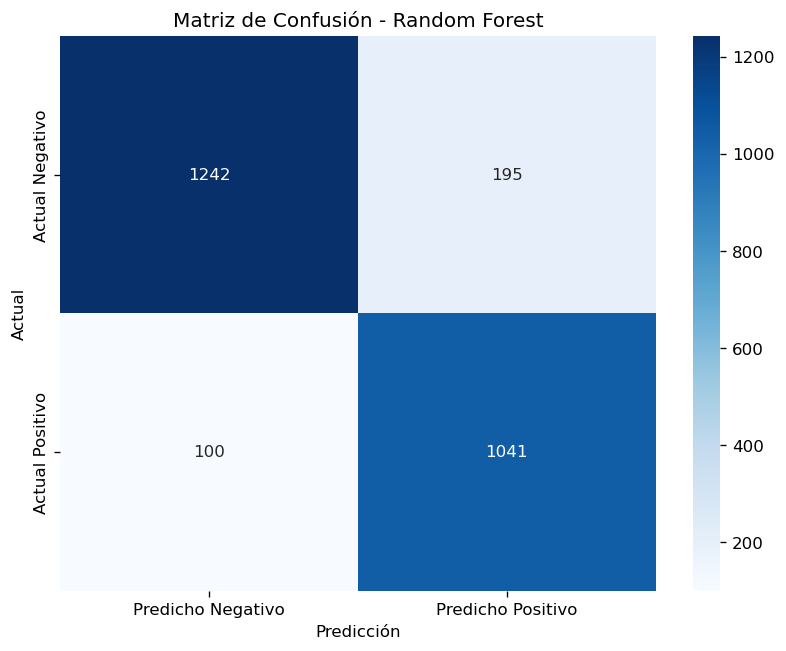

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1437
           1       0.84      0.91      0.88      1141

    accuracy                           0.89      2578
   macro avg       0.88      0.89      0.88      2578
weighted avg       0.89      0.89      0.89      2578

Random Forest Model Accuracy:  0.8914727289191244


In [47]:
#rfclf = RandomForestClassifier()
#rfclf.fit(X_train, y_train)
#predictions = rfclf.predict(X_test)

from sklearn.model_selection import GridSearchCV


# Definir el modelo y los parámetros para la búsqueda en cuadrícula
rf = RandomForestClassifier(random_state=0)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Mejor modelo encontrado
best_rf = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_rf.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

# Mostrar la exactitud del mejor modelo
print("Random Forest Model Accuracy: ", grid_search.best_score_)

### Uso de XGBoost con Validación Cruzada

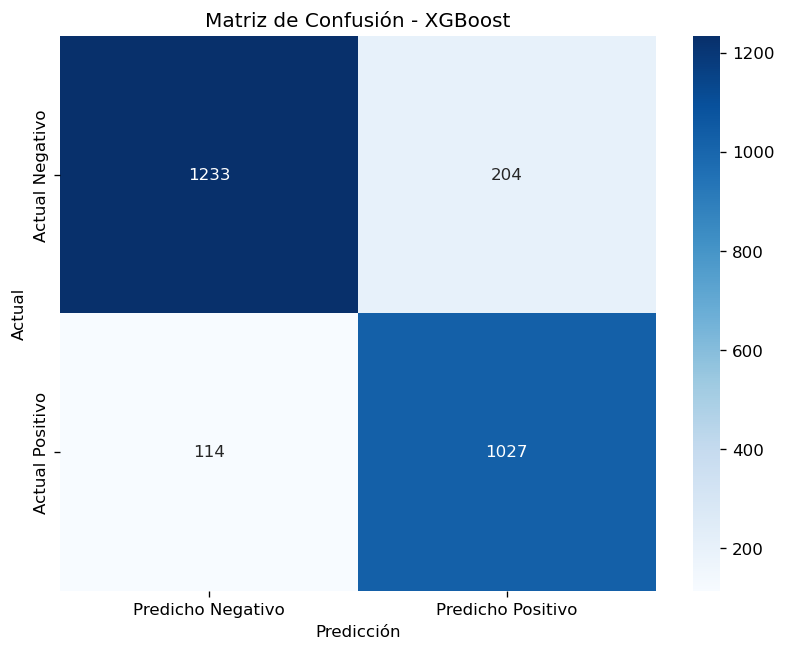

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1437
           1       0.83      0.90      0.87      1141

    accuracy                           0.88      2578
   macro avg       0.87      0.88      0.88      2578
weighted avg       0.88      0.88      0.88      2578

XGBoost Model Cross-Validation Accuracy:  0.8843382650618201


In [48]:
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Definir el modelo XGBoost
xgb_model = xgb.XGBClassifier(random_state=0)

# Realizar validación cruzada
cv_scores = cross_val_score(xgb_model, X_resampled, y_resampled, cv=5, scoring='accuracy')

# Ajustar el modelo en todo el conjunto de entrenamiento resampleado
xgb_model.fit(X_resampled, y_resampled)

# Predecir en el conjunto de prueba
y_pred = xgb_model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

# Mostrar la exactitud del modelo XGBoost con validación cruzada
print("XGBoost Model Cross-Validation Accuracy: ", cv_scores.mean())

### Uso de Modelos de Ensemble Avanzados

Fitting 5 folds for each of 18 candidates, totalling 90 fits


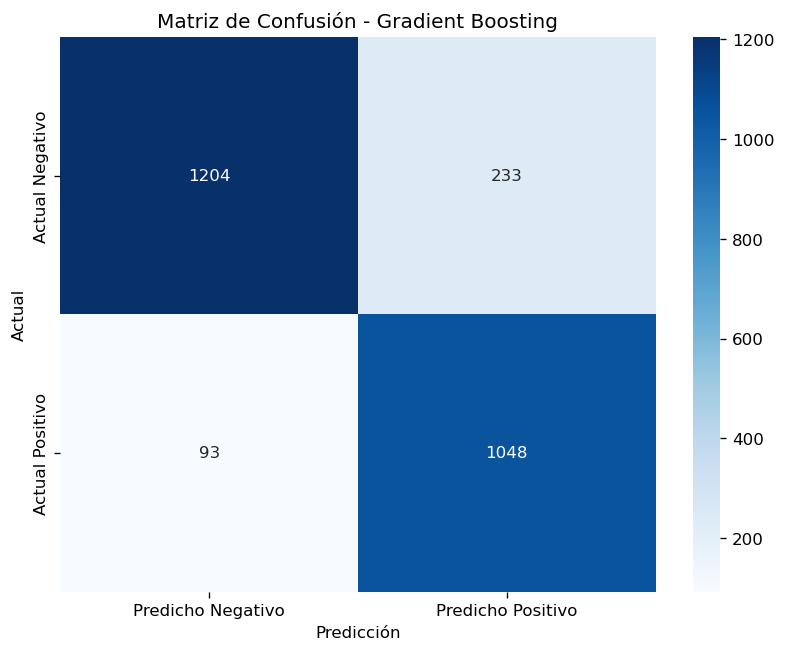

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1437
           1       0.82      0.92      0.87      1141

    accuracy                           0.87      2578
   macro avg       0.87      0.88      0.87      2578
weighted avg       0.88      0.87      0.87      2578

Gradient Boosting Model Accuracy:  0.884505944535055


In [49]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Definir el modelo Gradient Boosting
gb = GradientBoostingClassifier(random_state=0)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Mejor modelo encontrado
best_gb = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_gb.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Gradient Boosting')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

# Mostrar la exactitud del mejor modelo
print("Gradient Boosting Model Accuracy: ", grid_search.best_score_)

###  Ingeniería de Características Adicionales

Fitting 5 folds for each of 18 candidates, totalling 90 fits


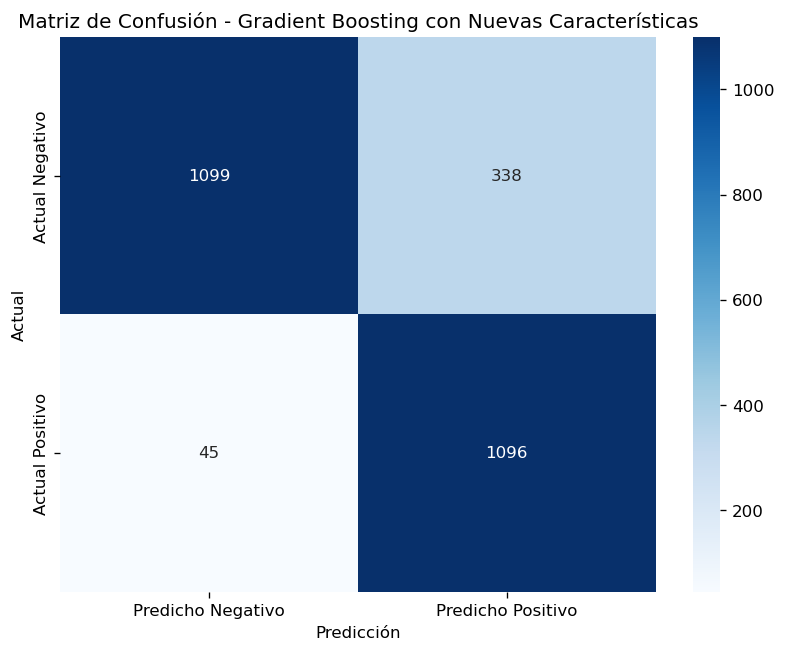

              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1437
           1       0.76      0.96      0.85      1141

    accuracy                           0.85      2578
   macro avg       0.86      0.86      0.85      2578
weighted avg       0.87      0.85      0.85      2578

Gradient Boosting Model Accuracy con Nuevas Características:  0.8595763512396971


In [84]:
# Crear características adicionales
filtered_df['engine_confidence'] = filtered_df['engine'].astype(str) + '_' + filtered_df['threatInfo.confidenceLevel'].astype(str)
filtered_df['engine_classification'] = filtered_df['engine'].astype(str) + '_' + filtered_df['threatInfo.classification'].astype(str)

# Codificar las nuevas características utilizando pd.get_dummies
engine_confidence_encoded = pd.get_dummies(filtered_df['engine_confidence'], prefix='engine_confidence')
engine_classification_encoded = pd.get_dummies(filtered_df['engine_classification'], prefix='engine_classification')

# Combinar todas las características codificadas en un solo DataFrame
characteristics_encoded = pd.concat([indicator_list_encoded, engine_encoded, classification_encoded, confidence_level_encoded, detection_type_encoded, engine_confidence_encoded, engine_classification_encoded], axis=1)

# Definir X y y
X = characteristics_encoded
y = filtered_df['threatInfo.analystVerdict.encoded']

# Convertir y a entero si es necesario
y = y.astype(int)

# Convertir todos los valores booleanos en X a enteros
X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Dividir los datos en conjuntos de entrenamiento y prueba con un tamaño de prueba del 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Aplicar SMOTE para equilibrar las clases
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Definir el modelo Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=0)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Realizar la búsqueda en cuadrícula
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Mejor modelo encontrado
best_gb = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_gb.predict(X_test)

# Calcular la matriz de confusión
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Gradient Boosting con Nuevas Características')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

# Mostrar la exactitud del mejor modelo
print("Gradient Boosting Model Accuracy con Nuevas Características: ", grid_search.best_score_)

## Modelo de Regresión Logística

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejor F1-Score: 0.8529411764705883
Mejor Umbral: 0.36385609763525917


C:\Users\alber\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


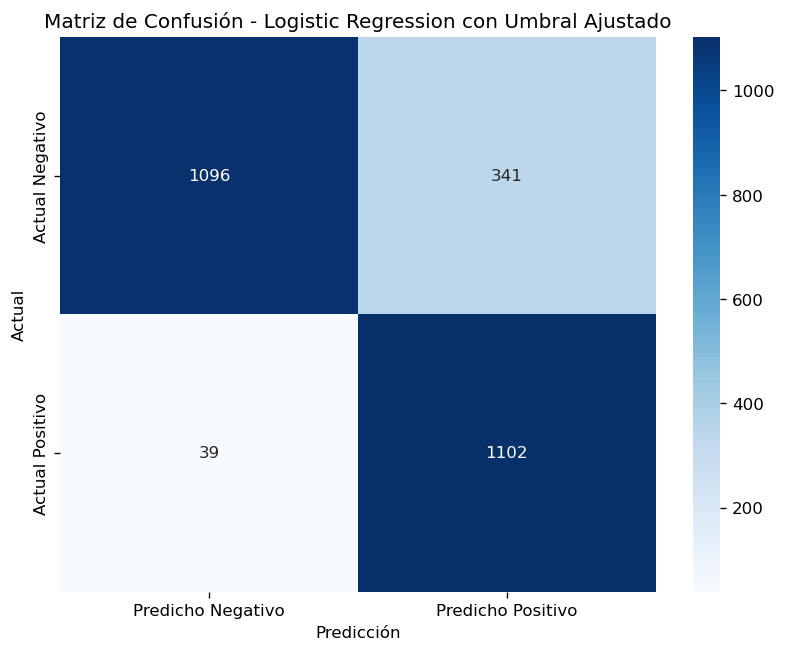

              precision    recall  f1-score   support

           0       0.97      0.76      0.85      1437
           1       0.76      0.97      0.85      1141

    accuracy                           0.85      2578
   macro avg       0.86      0.86      0.85      2578
weighted avg       0.88      0.85      0.85      2578

Logistic Regression Model Accuracy con Umbral Ajustado:  0.8595762807713326


In [89]:
#lregr = LogisticRegression()
#lregr.fit(X_train, y_train)
#predictions = lregr.predict(X_test)




#accuracy = accuracy_score(y_test, predictions)
#print("Linear Regression Model Accuracy: ", accuracy)


# Definir el modelo Logistic Regression
lr = LogisticRegression(random_state=0, max_iter=1000)
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Mejor modelo encontrado
best_lr = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_lr.predict(X_test)

# Obtener las probabilidades predichas
y_probs = best_lr.predict_proba(X_test)[:, 1]

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calcular F1-Score para cada umbral
f1_scores = 2 * (precision * recall) / (precision + recall)

# Encontrar el índice del mejor F1-Score
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]

print(f"Mejor F1-Score: {f1_scores[best_index]}")
print(f"Mejor Umbral: {best_threshold}")

# Aplicar el mejor umbral para las predicciones
y_pred_adjusted = (y_probs >= best_threshold).astype(int)

# Calcular la nueva matriz de confusión
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)

# Visualizar la nueva matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Logistic Regression con Umbral Ajustado')
plt.show()

# Mostrar el nuevo reporte de clasificación
print(classification_report(y_test, y_pred_adjusted))

# Mostrar la exactitud del mejor modelo
print("Logistic Regression Model Accuracy con Umbral Ajustado: ", grid_search.best_score_)


In [ ]:
### Implementación de Stacking

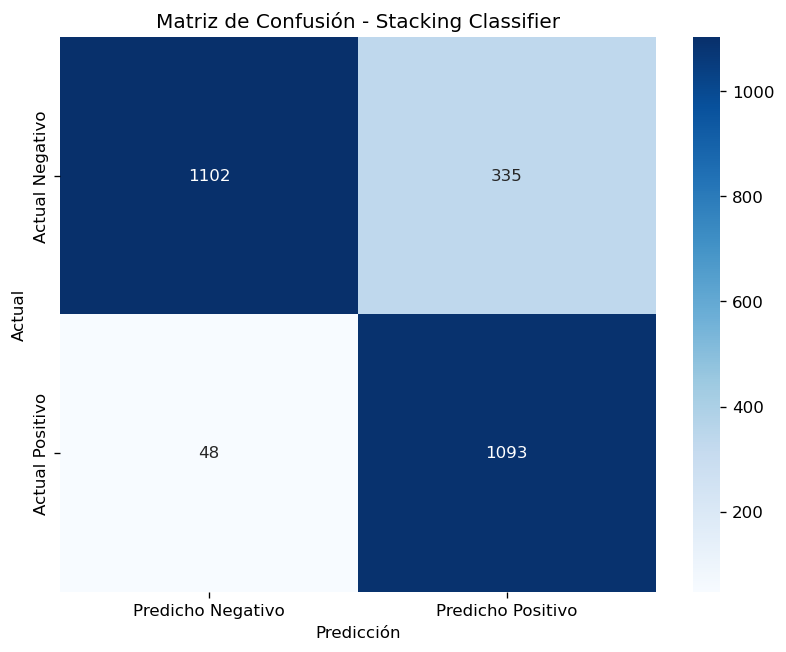

              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1437
           1       0.77      0.96      0.85      1141

    accuracy                           0.85      2578
   macro avg       0.86      0.86      0.85      2578
weighted avg       0.87      0.85      0.85      2578

Stacking:  0.8595762807713326


In [91]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Definir los modelos base y el modelo meta
estimators = [
    ('decision_tree', DecisionTreeClassifier(random_state=0)),
    ('random_forest', RandomForestClassifier(random_state=0))
]
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=0)
)

# Dividir los datos en conjuntos de entrenamiento y prueba con un tamaño de prueba del 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Aplicar SMOTE para equilibrar las clases
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Entrenar el modelo de stacking
stacking_clf.fit(X_resampled, y_resampled)

# Predecir en el conjunto de prueba
y_pred = stacking_clf.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Negativo', 'Predicho Positivo'], yticklabels=['Actual Negativo', 'Actual Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Stacking Classifier')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

# Mostrar la exactitud del mejor modelo
print("Stacking: ", grid_search.best_score_)

In [1]:
### Importancia de las características

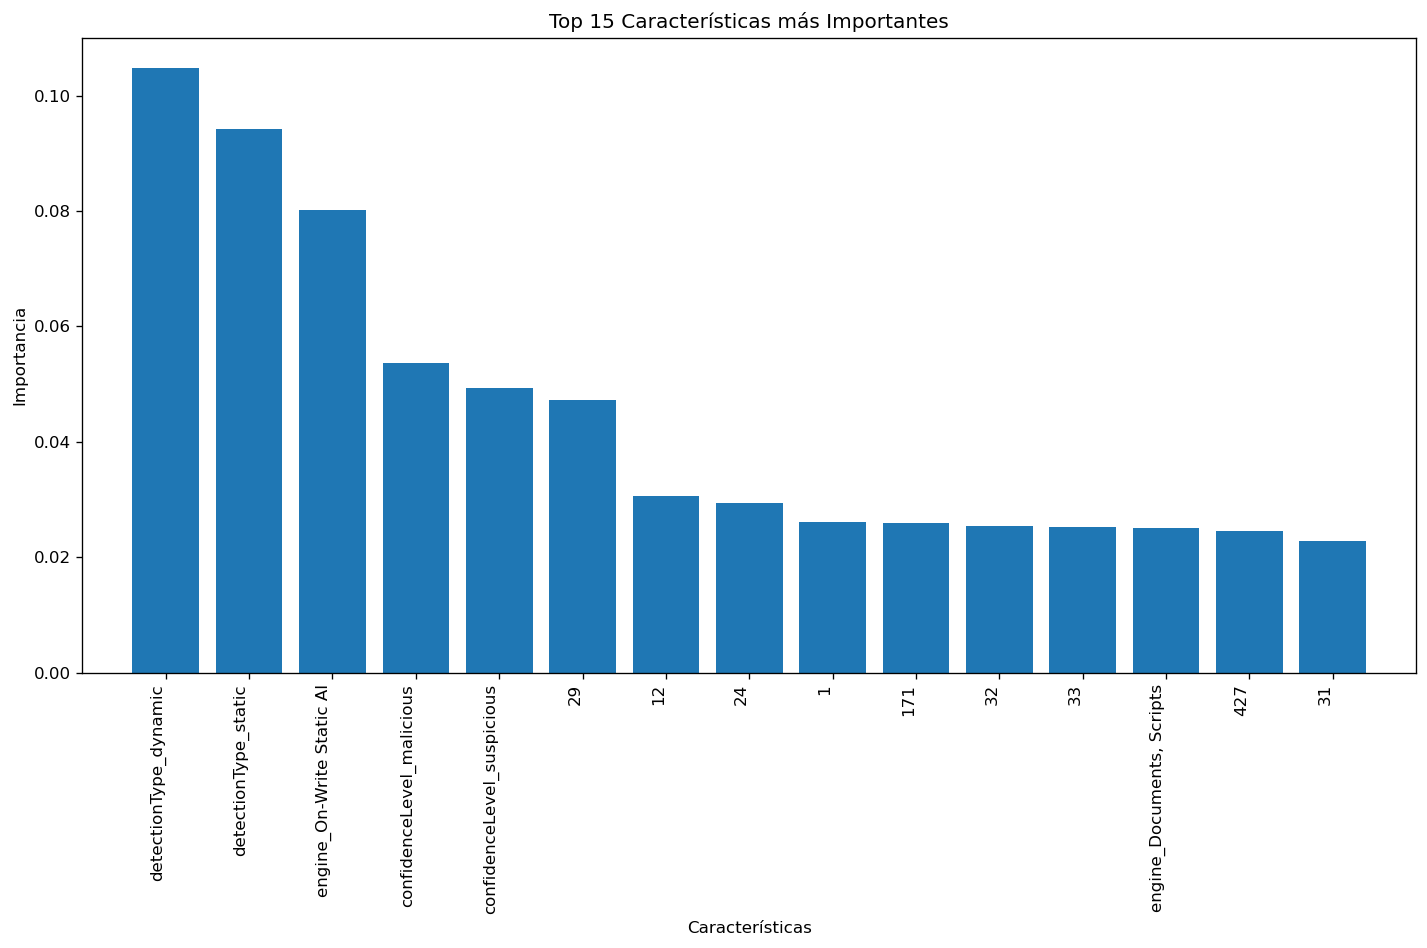

1. detectionType_dynamic (0.10474839328764386)
2. detectionType_static (0.09426829805049054)
3. engine_On-Write Static AI (0.0801367163044388)
4. confidenceLevel_malicious (0.05367594033866387)
5. confidenceLevel_suspicious (0.04933543244588953)
6. 29 (0.04721282497256128)
7. 12 (0.030567367283660253)
8. 24 (0.029399762998627645)
9. 1 (0.02615720462833054)
10. 171 (0.025897321966441143)
11. 32 (0.025341289444915868)
12. 33 (0.025176112671853174)
13. engine_Documents, Scripts (0.02499053582729863)
14. 427 (0.024577571947489222)
15. 31 (0.02272848099018312)


In [41]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Entrenar un modelo de Random Forest para evaluar la importancia de las características
rf = RandomForestClassifier(random_state=0)
rf.fit(X_resampled, y_resampled)

# Obtener la importancia de las características
importances = rf.feature_importances_

# Ordenar las características por importancia
indices = np.argsort(importances)[::-1]

# Seleccionar las 15 características más importantes
top_n = 15
top_indices = indices[:top_n]

# Visualizar la importancia de las características
plt.figure(figsize=(12, 8))
plt.title("Top 15 Características más Importantes")
plt.bar(range(top_n), importances[top_indices], align="center")
plt.xticks(range(top_n), X.columns[top_indices], rotation=90, ha='right')
plt.xlim([-1, top_n])
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

# Mostrar las 15 características más importantes
for i in range(top_n):
    print(f"{i + 1}. {X.columns[top_indices[i]]} ({importances[top_indices[i]]})")

## Modelo de Naive Bayes

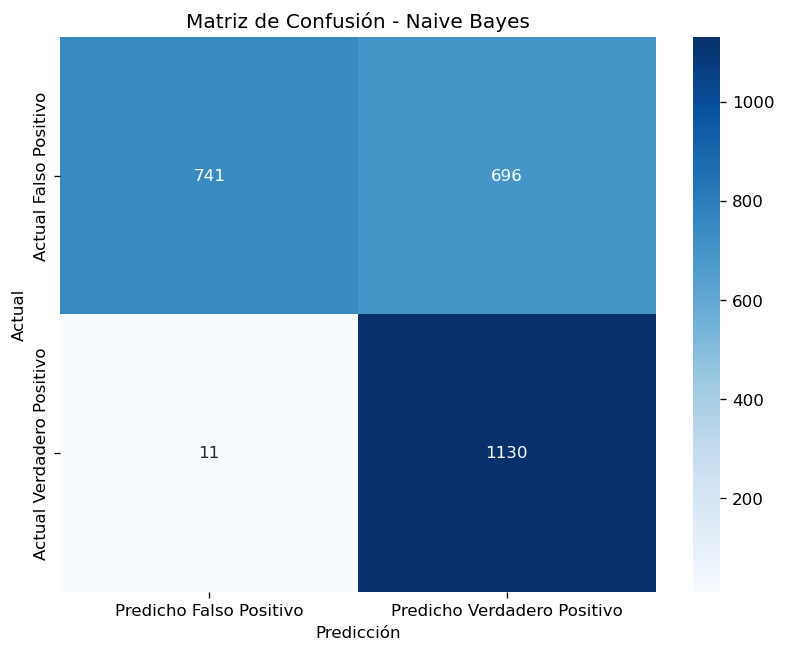

                      precision    recall  f1-score   support

    Falsos Positivos       0.99      0.52      0.68      1437
Verdaderos Positivos       0.62      0.99      0.76      1141

            accuracy                           0.73      2578
           macro avg       0.80      0.75      0.72      2578
        weighted avg       0.82      0.73      0.71      2578



In [59]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el modelo GaussianNB
model = GaussianNB()

# Entrenar el modelo con los datos balanceados
model.fit(X_resampled, y_resampled)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Falso Positivo', 'Predicho Verdadero Positivo'], yticklabels=['Actual Falso Positivo', 'Actual Verdadero Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Naive Bayes')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))


## Modelo SVM

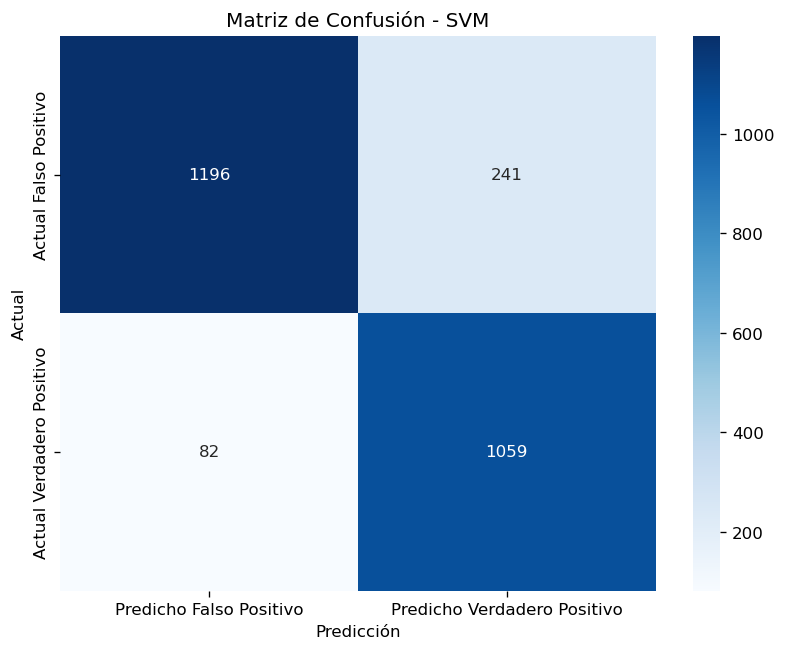

                      precision    recall  f1-score   support

    Falsos Positivos       0.94      0.83      0.88      1437
Verdaderos Positivos       0.81      0.93      0.87      1141

            accuracy                           0.87      2578
           macro avg       0.88      0.88      0.87      2578
        weighted avg       0.88      0.87      0.88      2578



In [53]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el modelo SVM
model = SVC()

# Entrenar el modelo con los datos balanceados
model.fit(X_resampled, y_resampled)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Falso Positivo', 'Predicho Verdadero Positivo'], yticklabels=['Actual Falso Positivo', 'Actual Verdadero Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - SVM')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))

In [28]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
predictions = gbc.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Gradient Boosting Model Accuracy: ", accuracy)

Gradient Boosting Model Accuracy:  0.6521739130434783


## AdaBoost

C:\Users\alber\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


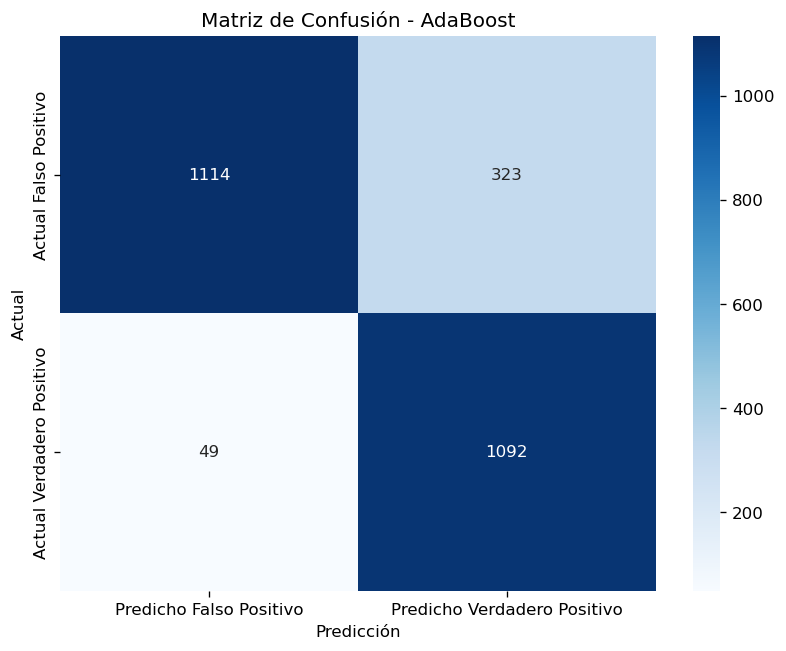

                      precision    recall  f1-score   support

    Falsos Positivos       0.96      0.78      0.86      1437
Verdaderos Positivos       0.77      0.96      0.85      1141

            accuracy                           0.86      2578
           macro avg       0.86      0.87      0.86      2578
        weighted avg       0.88      0.86      0.86      2578



In [56]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el modelo AdaBoost con árboles de decisión como clasificadores débiles
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=0)

# Entrenar el modelo con los datos balanceados
model.fit(X_resampled, y_resampled)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Falso Positivo', 'Predicho Verdadero Positivo'], yticklabels=['Actual Falso Positivo', 'Actual Verdadero Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - AdaBoost')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))

## Modelo de XGBoost

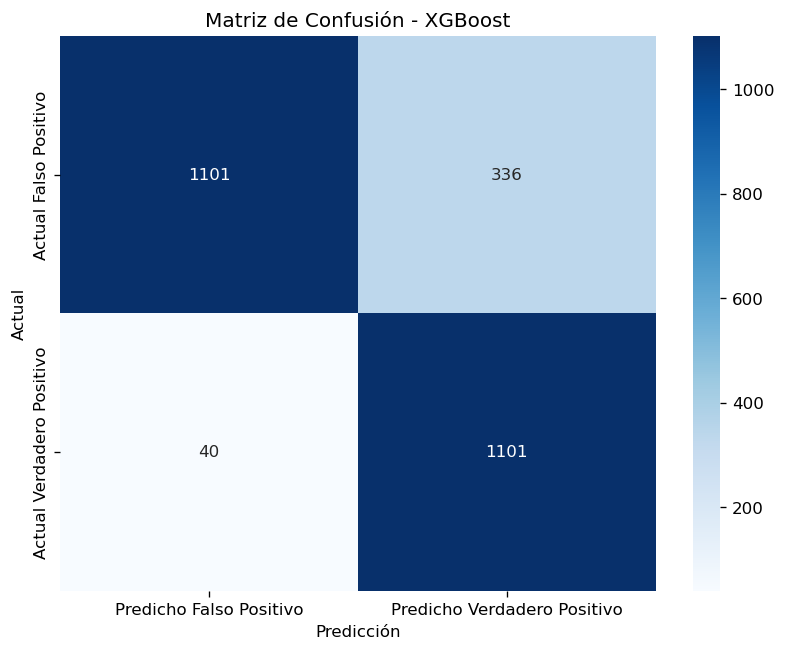

                      precision    recall  f1-score   support

    Falsos Positivos       0.96      0.77      0.85      1437
Verdaderos Positivos       0.77      0.96      0.85      1141

            accuracy                           0.85      2578
           macro avg       0.87      0.87      0.85      2578
        weighted avg       0.88      0.85      0.85      2578



In [57]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Crear los DMatrix para el entrenamiento y el conjunto de prueba
dtrain = xgb.DMatrix(X_resampled, label=y_resampled)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parámetros del modelo
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'eta': 0.1,
    'eval_metric': 'logloss'
}

# Entrenar el modelo
bst = xgb.train(params, dtrain, num_boost_round=50)

# Predecir en el conjunto de prueba
y_pred_prob = bst.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Falso Positivo', 'Predicho Verdadero Positivo'], yticklabels=['Actual Falso Positivo', 'Actual Verdadero Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Falsos Positivos', 'Verdaderos Positivos']))

# Evaluación y comparativa

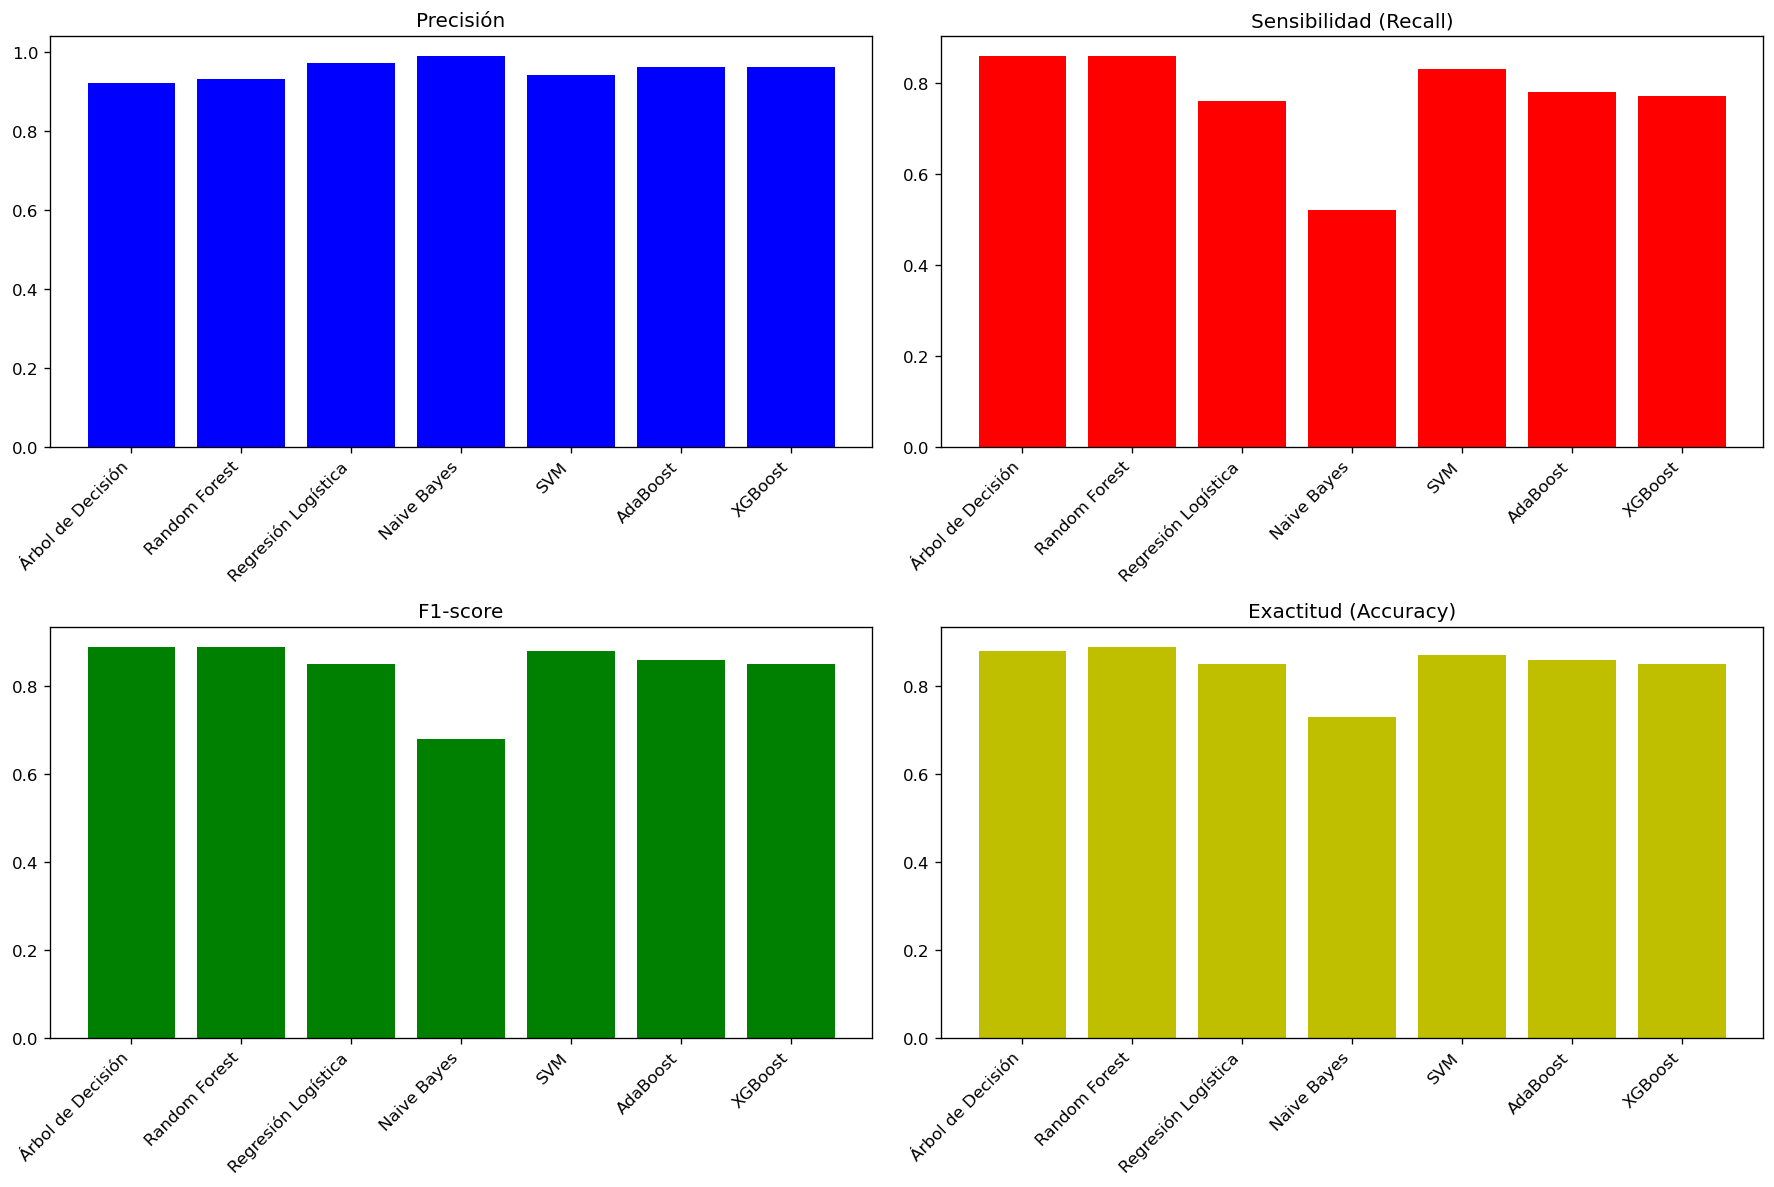

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de las métricas
models = ['Árbol de Decisión', 'Random Forest', 'Regresión Logística', 'Naive Bayes', 'SVM', 'AdaBoost', 'XGBoost']
precision = [0.92, 0.93, 0.97, 0.99, 0.94, 0.96, 0.96]
recall = [0.86, 0.86, 0.76, 0.52, 0.83, 0.78, 0.77]
f1_score = [0.89, 0.89, 0.85, 0.68, 0.88, 0.86, 0.85]
accuracy = [0.88, 0.89, 0.85, 0.73, 0.87, 0.86, 0.85]

x = np.arange(len(models))

# Crear subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Precision
axs[0, 0].bar(x, precision, color='b')
axs[0, 0].set_title('Precisión')
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(models, rotation=45, ha='right')

# Recall
axs[0, 1].bar(x, recall, color='r')
axs[0, 1].set_title('Sensibilidad (Recall)')
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(models, rotation=45, ha='right')

# F1-score
axs[1, 0].bar(x, f1_score, color='g')
axs[1, 0].set_title('F1-score')
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(models, rotation=45, ha='right')

# Accuracy
axs[1, 1].bar(x, accuracy, color='y')
axs[1, 1].set_title('Exactitud (Accuracy)')
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(models, rotation=45, ha='right')

plt.tight_layout()
plt.show()